In [126]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import gc
import pathlib

In [130]:
%run ../wmis_gnn_py/util/metis.py

In [20]:
metis_to_nx??

Signature: metis_to_nx(filename: str)
Docstring: <no docstring>
Source:   
def metis_to_nx(filename: str):
    G = nx.Graph()

    with open(filename, "r") as f:
        for line_num, line in enumerate(f):
            if line_num == 0:
                n_vertices, n_edges, graph_type = map(int, line.split(" "))

                assert n_vertices >= 0
                assert n_edges >= 0
                assert graph_type == 10

                continue

            if line[0] == "%":
                continue

            node_weight, *neighbors = map(int, line.split(" "))

            assert node_weight > 0

            G.add_node(line_num, weight=node_weight)

            for v in neighbors:
                assert 1 <= v <= n_vertices
                G.add_edge(line_num, v)

        assert G.size() == n_edges

    return G
File:      /gpfs/gibbs/project/karbasi/cz397/CPSC583-Project/wmis_gnn_py/util/metis.py
Type:      function


In [123]:
def summarize_graph(G: nx.Graph, name: str):
    n_nodes = G.order()
    n_edges = G.size()
    avg_deg = 2*n_edges / n_nodes
    n_components = nx.number_connected_components(G)
    n_isolates = nx.number_of_isolates(G)
    sum_weights = sum(G.nodes[v]["weight"] for v in range(1, G.order()+1))
    # s_metric = nx.s_metric(G, normalized=False)

    # is_chordal = nx.is_chordal(G)
    # is_planar = nx.is_planar(G)
    # is_eulerian = nx.is_eulerian(G)
    # is_regular = nx.is_regular(G)
    
    return {"name": name,
            "n_nodes": n_nodes, 
            "n_edges": n_edges, 
            "avg_deg": avg_deg, 
            "n_components": n_components, 
            "n_isolates": n_isolates,
            "sum_weights": sum_weights,
            # "s_metric": s_metric,
            # "is_planar": is_planar,
            # "is_chordal": is_chordal,
            # "is_eulerian": is_eulerian,
            # "is_regular": is_regular,
           }

# Small Erdos-Reyni Graphs

In [131]:
rows = []

ind_base = pathlib.Path("../data/erdos_reyni_small/label/")

graph_paths = list(yield_metis_filenames("../data/erdos_reyni_small/"))
ind_paths = set(path.stem for path in yield_solution_filenames(ind_base.resolve()))
for graph_path in tqdm(graph_paths):
    G = metis_to_nx(graph_path.resolve())
    summary_dict = summarize_graph(G, graph_path.stem)
    summary_dict["kamis_weight"] = -np.inf
    
    if graph_path.stem in ind_paths:
        ind_path = ind_base / graph_path.with_suffix(".ind").name
        solution_to_nx(G, ind_path.resolve())
        solution_weight = sum(G.nodes[v]["weight"] for v in range(1, G.order()+1) if G.nodes[v]["solution"] == 1)
        summary_dict["kamis_weight"] = solution_weight
    
    rows.append(pd.Series(summary_dict))
    
    gc.collect()
    
df_er = pd.DataFrame(rows).set_index("name")
df_er

100%|██████████| 1000/1000 [05:39<00:00,  2.95it/s]


,n_nodes,n_edges,avg_deg,n_components,n_isolates,sum_weights,kamis_weight
name,,,,,,,
erdos-reyni-n200-p0.1--maxw400-seed20_0,200,2013,20.13,1,0,37549,9554
erdos-reyni-n200-p0.1--maxw400-seed20_1,200,2011,20.11,1,0,44998,11051
erdos-reyni-n200-p0.1--maxw400-seed20_10,200,1971,19.71,1,0,42487,10119
erdos-reyni-n200-p0.1--maxw400-seed20_100,200,1894,18.94,1,0,40930,10334
erdos-reyni-n200-p0.1--maxw400-seed20_101,200,1905,19.05,1,0,37630,9988
...,...,...,...,...,...,...,...
erdos-reyni-n200-p0.1--maxw400-seed20_995,200,1981,19.81,1,0,37785,10143
erdos-reyni-n200-p0.1--maxw400-seed20_996,200,1942,19.42,1,0,41687,10311
erdos-reyni-n200-p0.1--maxw400-seed20_997,200,1996,19.96,1,0,42427,10586


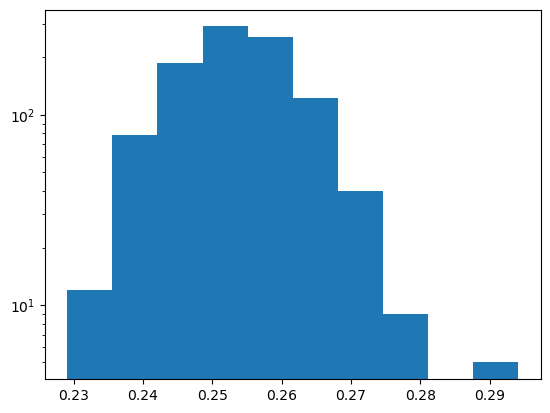

In [133]:
plt.hist(df_er.kamis_weight / df_er.sum_weights, log=True)
plt.show()

<AxesSubplot: >

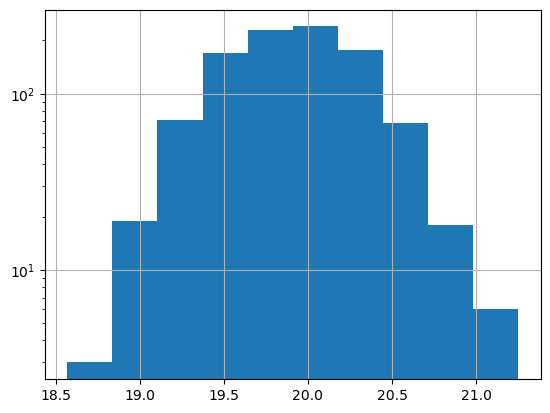

In [134]:
df_er.avg_deg.hist(log=True)

<AxesSubplot: >

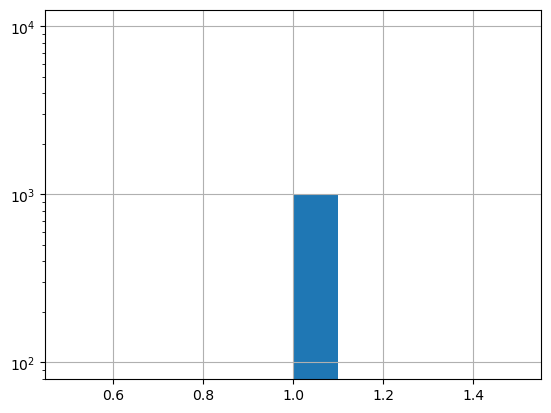

In [135]:
df_er.n_components.hist(log=True)

# PACE 2019 Competition Graphs

In [ ]:
rows = []

filepaths = list(yield_metis_filenames("../data/pace_unweighted/"))
for filepath in tqdm(filepaths):
    path = filepath.resolve()
    # print(path)
    G = metis_to_nx(path)
    rows.append(pd.Series(summarize_graph(G, path.stem)))
    
    gc.collect()
    
df_pace = pd.DataFrame(rows).set_index("name")
df_pace

<AxesSubplot: >

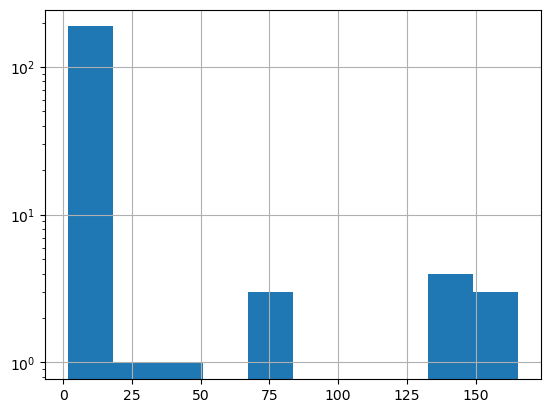

In [106]:
df_pace.avg_deg.hist(log=True)

<AxesSubplot: >

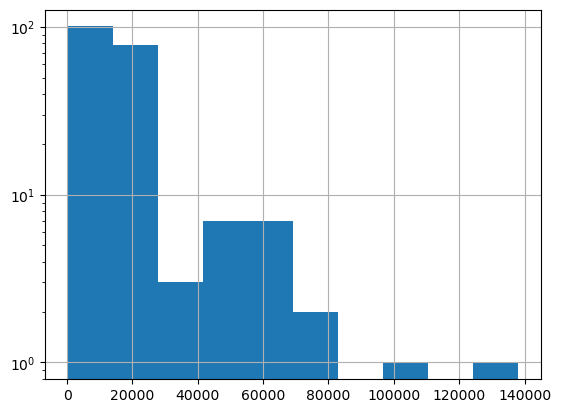

In [108]:
df_pace.n_nodes.hist(log=True)

<AxesSubplot: >

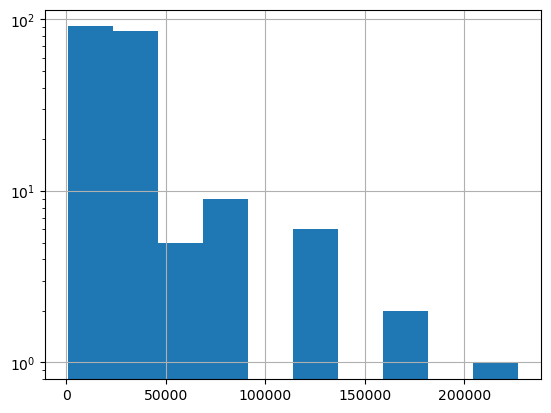

In [110]:
df_pace.n_edges.hist(log=True)

<AxesSubplot: >

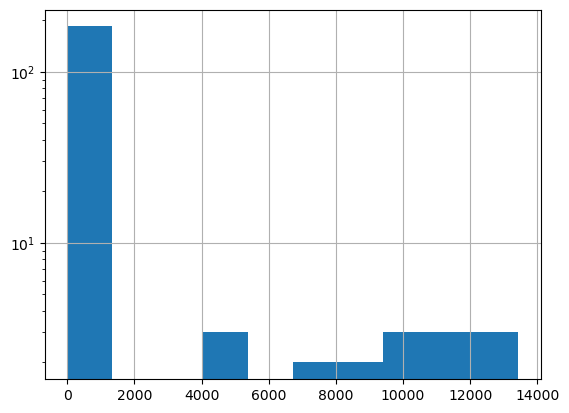

In [109]:
df_pace.n_components.hist(log=True)